## Download the Data

We will use the [DUTS-TE](http://saliencydetection.net/duts/) dataset for training. It has 5,019
images we will use 90% for training and rest for validation. DUTS is
a object segmentation dataset. which contain diversified textures and
structures common to real-world images in both foreground and background.

In [1]:
!wget http://saliencydetection.net/duts/download/DUTS-TE.zip
!unzip -q DUTS-TE.zip

--2024-02-24 06:33:29--  http://saliencydetection.net/duts/download/DUTS-TE.zip
Resolving saliencydetection.net (saliencydetection.net)... 36.55.239.177
Connecting to saliencydetection.net (saliencydetection.net)|36.55.239.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139799089 (133M) [application/zip]
Saving to: ‘DUTS-TE.zip’

DUTS-TE.zip         100%[===================>] 133.32M  4.79MB/s    in 28s     

2024-02-24 06:33:57 (4.81 MB/s) - ‘DUTS-TE.zip’ saved [139799089/139799089]



In [2]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend

## Define Hyperparameters

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
OUT_CLASSES = 1
TRAIN_SPLIT_RATIO = 0.90
DATA_DIR = "./DUTS-TE/"

## Create TensorFlow Dataset

We will use `load_paths()` to load and split the paths into train and validation set, and
`load_dataset()` to convert paths into `tf.data.Dataset` object.

In [5]:
def load_paths(path, split_ratio):
    images = sorted(glob(os.path.join(path, "DUTS-TE-Image/*")))[:140]
    masks = sorted(glob(os.path.join(path, "DUTS-TE-Mask/*")))[:140]
    len_ = int(len(images) * split_ratio)
    return (images[:len_], masks[:len_]), (images[len_:], masks[len_:])


def read_image(path, size, mode):
    x = keras.utils.load_img(path, target_size=size, color_mode=mode)
    x = keras.utils.img_to_array(x)
    x = (x / 255.0).astype(np.float32)
    return x


def preprocess(x_batch, y_batch, img_size, out_classes):
    def f(_x, _y):
        _x, _y = _x.decode(), _y.decode()
        _x = read_image(_x, (img_size, img_size), mode="rgb")  # image
        _y = read_image(_y, (img_size, img_size), mode="grayscale")  # mask
        return _x, _y

    images, masks = tf.numpy_function(f, [x_batch, y_batch], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, out_classes])
    return images, masks


def load_dataset(image_paths, mask_paths, img_size, out_classes, batch, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_paths, val_paths = load_paths(DATA_DIR, TRAIN_SPLIT_RATIO)

train_dataset = load_dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False
)

print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


## Visualize Data

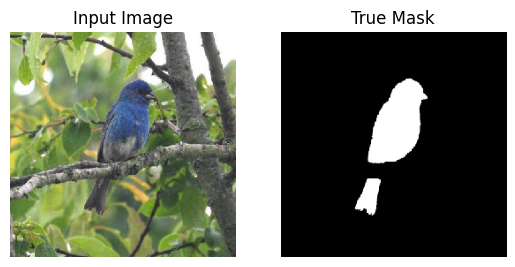

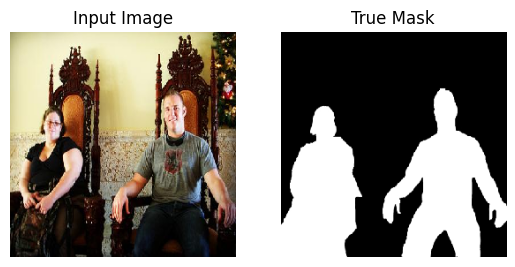

In [54]:
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis("off")
    plt.show()


for image, mask in train_dataset.take(2):
    display([image[1], mask[1]])

### Model Definition

In [130]:
from keras.layers import *

def EncoderMiniBlock(n_filters, inputs, dropout_prob=0.15, max_pooling=True):
    conv = Conv2D(n_filters,
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)


    conv = Conv2D(n_filters,
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    next_layer = Conv2D(n_filters,
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    conv = BatchNormalization()(conv, training=False)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv


    skip_connection = conv
    return next_layer, skip_connection

def DecoderMiniBlock(n_filters, prev_layer_input, skip_layer_input):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same')(conv)
    return conv

def get_model(img_size, num_classes):
    inputs = keras.Input(img_size)

    # [First half of the network: downsampling inputs]
    x0, s0 = EncoderMiniBlock(64, inputs)
    x1, s1 = EncoderMiniBlock(128, x0)
    x2, s2 = EncoderMiniBlock(256, x1)

    x = DecoderMiniBlock(256, x2, s2)
    x = DecoderMiniBlock(128, x, s1)
    x = DecoderMiniBlock(64, x, s0)


    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model((IMAGE_SIZE, IMAGE_SIZE, 3), OUT_CLASSES)
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_275 (Conv2D)         (None, 256, 256, 64)         1792      ['input_33[0][0]']            
                                                                                                  
 conv2d_276 (Conv2D)         (None, 256, 256, 64)         36928     ['conv2d_275[0][0]']          
                                                                                                  
 batch_normalization_119 (B  (None, 256, 256, 64)         256       ['conv2d_276[0][0]']          
 atchNormalization)                                                                        

### Compile the Model

In [131]:
optimizer = keras.optimizers.Adam(learning_rate=1e-2, epsilon=1e-8)
# Compile model.
model.compile(
    loss="mse",
    optimizer='adam',
    metrics=['accuracy'],
)

### Train the Model

In [132]:
history = model.fit(train_dataset, validation_data=val_dataset, batch_size=8, epochs=30)

Epoch 1/30
16/16 [==============================] - 12s 483ms/step - loss: 0.1530 - accuracy: 0.7862 - val_loss: 0.1372 - val_accuracy: 0.8344
Epoch 2/30
16/16 [==============================] - 8s 471ms/step - loss: 0.1399 - accuracy: 0.8084 - val_loss: 0.1224 - val_accuracy: 0.8344
Epoch 3/30
16/16 [==============================] - 7s 464ms/step - loss: 0.1357 - accuracy: 0.8084 - val_loss: 0.1263 - val_accuracy: 0.8344
Epoch 4/30
16/16 [==============================] - 8s 469ms/step - loss: 0.1376 - accuracy: 0.8084 - val_loss: 0.1278 - val_accuracy: 0.8344
Epoch 5/30
16/16 [==============================] - 8s 465ms/step - loss: 0.1340 - accuracy: 0.8036 - val_loss: 0.1215 - val_accuracy: 0.8344
Epoch 6/30
16/16 [==============================] - 7s 459ms/step - loss: 0.1308 - accuracy: 0.8091 - val_loss: 0.1201 - val_accuracy: 0.8344
Epoch 7/30
16/16 [==============================] - 7s 461ms/step - loss: 0.1291 - accuracy: 0.8084 - val_loss: 0.1267 - val_accuracy: 0.8344
Epoch

### Loss change

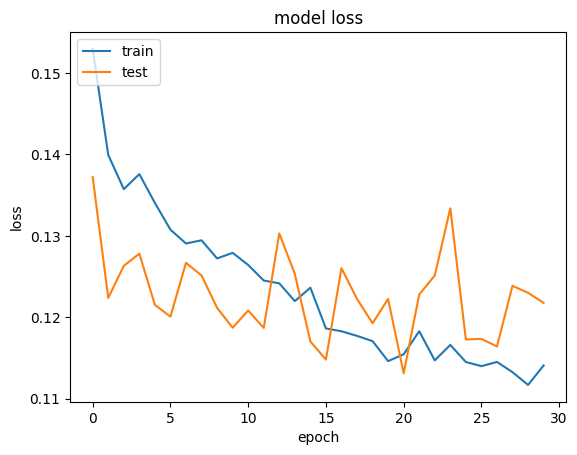

In [134]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Make Predictions

In [121]:
def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)


1/1 [==============================] - 0s 40ms/step


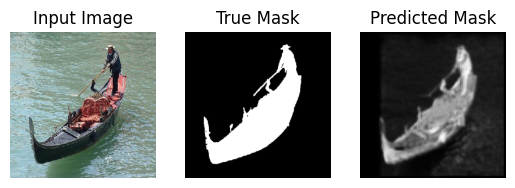

In [141]:
for image, mask in val_dataset.take(1):
    pred_mask = model.predict(image)
    display([image[1], mask[1], normalize_output(pred_mask[1])])
